In [ ]:
# TASKS

# 1. IMPORT
# 2. PREPROCESSING
# 3. MODELLING
# 4. TRAINING

In [179]:
#Importing the libraries

from torch import nn, randn, tensor, optim, argmax, no_grad, save, manual_seed, cuda
import torch.nn.functional as F
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
def seed_everything(seed: int) -> None:
    '''Seeds the Code so that we get predictable outputs'''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    manual_seed(seed)
    if cuda.is_available():
        cuda.manual_seed(SEED)

seed_everything(42)


In [7]:
import os
import numpy as np


def read_data():
    pathname = os.path.dirname(sys.argv[0])
    path = os.path.abspath(pathname)
    img_width, img_height = 150, 150

    top_model_weights_path = 'model.h5'

    train_data_dir = os.path.join('data', 'train')
    validation_data_dir = os.path.join('data', 'validation')
    cats_train_path = os.path.join(path, train_data_dir, 'cats')
 
    nb_train_samples = 2 * len([name for name in os.listdir(cats_train_path)
                            if os.path.isfile(
                                os.path.join(cats_train_path, name))])

    EPOCHS = 10
    BATCH_SIZE = 10

In [52]:
import os
from torch.utils.data import Dataset
from PIL import Image
import glob
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from pathlib import Path

class CatsnDogsDataset(Dataset):
    dataset_folder_name = 'data'
    
    @staticmethod
    def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
        """Finds the class folders in a dataset.

        See :class:`DatasetFolder` for details.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    

    def __init__(self, root, train=True, transform=None):
        # self.dataset_folder_name = dataset_folder_name
        self.samples = []
        self.EXTENSION = 'jpg'
        self.root = root
        self.transform = transform

        self.split_dir = 'train' if train else 'validation'
        
        self.split_dir = os.path.join(
            self.root, self.dataset_folder_name, self.split_dir)
        
        _, self.classes_dict = self.find_classes(self.split_dir)
    
        self.image_paths = sorted(glob.iglob(os.path.join(
            self.split_dir, '**', '*.%s' % self.EXTENSION), recursive=True))
    
    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, index):
        filepath = self.image_paths[index]
        # img = Image.open(filepath)
        # img = img.convert("RGB")

        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = Path(filepath).parent.absolute().name

        if self.transform:  
            '''Performing augmentation'''   
            image = self.transform(image=image)

        return image, self.classes_dict[target]

In [94]:
def get_transforms(mode='train'):
    if mode == 'train':
        print('Performing training augmentation')
        train_transform = A.Compose(
            [
                A.SmallestMaxSize(max_size=160),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
                A.RandomCrop(height=128, width=128),
                A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.3),
                A.RandomBrightnessContrast(p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )
        return train_transform
    else:
        print('Performing val augmentation')

        val_transform = A.Compose(
            [
                A.SmallestMaxSize(max_size=160),
                A.CenterCrop(height=128, width=128),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ]
        )
        return val_transform

In [32]:
tt = get_transforms()

Performing training augmentation


In [95]:
train_dataset = CatsnDogsDataset(root=os.getcwd(), transform=get_transforms())
val_dataset = CatsnDogsDataset(root=os.getcwd(), transform=get_transforms(mode='val'))

Performing training augmentation
Performing val augmentation


In [118]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):

    dataset = copy.deepcopy(dataset)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        
        image, _ = dataset[idx]
        # print(image['image'].view(2,1,0))
        ax.ravel()[i].imshow(image['image'].permute(1, 2, 0))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

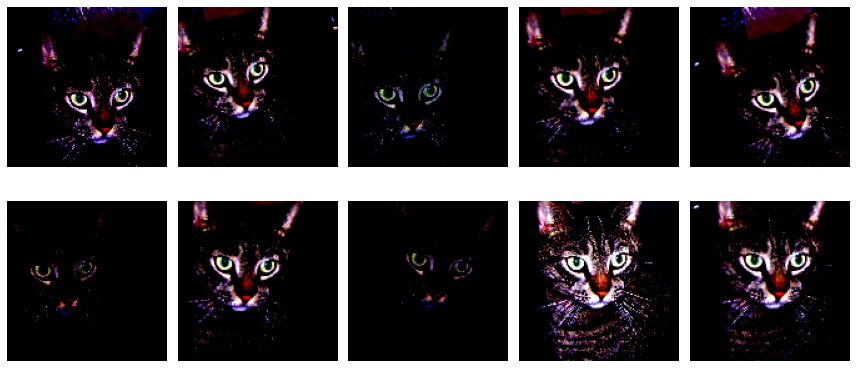

In [119]:
visualize_augmentations(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

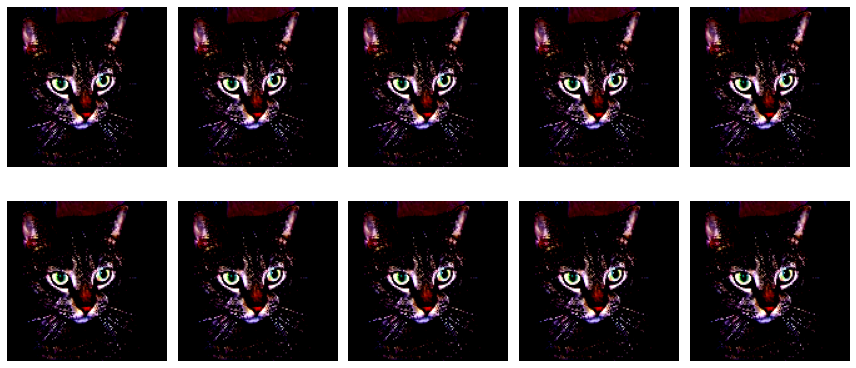

In [120]:
visualize_augmentations(val_dataset)

In [136]:
dataloader_args = dict(shuffle=True, num_workers=4, batch_size=128, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)
train_dataloader = DataLoader(train_dataset,**dataloader_args)
val_dataloader = DataLoader(val_dataset, **dataloader_args)

In [177]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 10, 3,padding=0, stride=2),  # 126
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 124
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),
            nn.MaxPool2d(2,2), # 62
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0, stride=1),  # 60
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 58
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),
            nn.MaxPool2d(2,2),  # 27
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 10, 3),  # 56
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(10, 10, 3),  # 4
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=9)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(10, 10, 1),  #1
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)



In [178]:
model = Net().to(device)

In [183]:
summary(model, (3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 63, 63]             280
              ReLU-2           [-1, 10, 63, 63]               0
       BatchNorm2d-3           [-1, 10, 63, 63]              20
           Dropout-4           [-1, 10, 63, 63]               0
            Conv2d-5           [-1, 16, 61, 61]           1,456
              ReLU-6           [-1, 16, 61, 61]               0
       BatchNorm2d-7           [-1, 16, 61, 61]              32
           Dropout-8           [-1, 16, 61, 61]               0
         MaxPool2d-9           [-1, 16, 30, 30]               0
           Conv2d-10           [-1, 10, 28, 28]           1,450
             ReLU-11           [-1, 10, 28, 28]               0
      BatchNorm2d-12           [-1, 10, 28, 28]              20
          Dropout-13           [-1, 10, 28, 28]               0
           Conv2d-14           [-1, 16,

In [175]:
train_acc = []
test_acc = []
train_losses = []
test_losses = []
EPOCHS = 15


def train(model, device, train_dataloader, optimizer):
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # print('weqwr', data, target)
        data, target = data['image'].to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, val_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for data, target in val_dataloader:
            data, target = data['image'].to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(val_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(val_dataloader.dataset),
        100. * correct / len(val_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(val_dataloader.dataset))

In [184]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.06)
EPOCHS = 15

for epoch in range(EPOCHS):
    print('EPOCH - ', epoch)
    train(model, device, train_dataloader, optimizer)
    scheduler.step()
    test(model, device, val_dataloader)

EPOCH -  0


Loss=1.8276035785675049 Batch_id=15 Accuracy=34.30: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]



Test set: Average loss: 1.8746, Accuracy: 500/1000 (50.00%)

EPOCH -  1


Loss=1.224990725517273 Batch_id=15 Accuracy=65.10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]



Test set: Average loss: 1.2394, Accuracy: 611/1000 (61.10%)

EPOCH -  2


Loss=0.8684579730033875 Batch_id=15 Accuracy=64.30: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]



Test set: Average loss: 0.8603, Accuracy: 700/1000 (70.00%)

EPOCH -  3


Loss=0.8153867721557617 Batch_id=15 Accuracy=65.00: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]



Test set: Average loss: 0.7097, Accuracy: 713/1000 (71.30%)

EPOCH -  4


Loss=0.6680026054382324 Batch_id=15 Accuracy=67.00: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]



Test set: Average loss: 0.6399, Accuracy: 694/1000 (69.40%)

EPOCH -  5


Loss=0.6818302273750305 Batch_id=15 Accuracy=67.30: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]



Test set: Average loss: 0.5903, Accuracy: 722/1000 (72.20%)

EPOCH -  6


Loss=0.5439008474349976 Batch_id=15 Accuracy=70.70: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]



Test set: Average loss: 0.5822, Accuracy: 713/1000 (71.30%)

EPOCH -  7


Loss=0.5800929665565491 Batch_id=15 Accuracy=70.90: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]



Test set: Average loss: 0.5766, Accuracy: 719/1000 (71.90%)

EPOCH -  8


Loss=0.5264544486999512 Batch_id=15 Accuracy=70.60: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.5523, Accuracy: 753/1000 (75.30%)

EPOCH -  9


Loss=0.5635929107666016 Batch_id=15 Accuracy=69.50: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]



Test set: Average loss: 0.5531, Accuracy: 749/1000 (74.90%)

EPOCH -  10


Loss=0.6840189695358276 Batch_id=15 Accuracy=70.40: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]



Test set: Average loss: 0.5339, Accuracy: 758/1000 (75.80%)

EPOCH -  11


Loss=0.5486924648284912 Batch_id=15 Accuracy=72.90: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]



Test set: Average loss: 0.5205, Accuracy: 772/1000 (77.20%)

EPOCH -  12


Loss=0.5985909700393677 Batch_id=15 Accuracy=71.00: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]



Test set: Average loss: 0.5170, Accuracy: 775/1000 (77.50%)

EPOCH -  13


Loss=0.5699299573898315 Batch_id=15 Accuracy=72.80: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]



Test set: Average loss: 0.5141, Accuracy: 776/1000 (77.60%)

EPOCH -  14


Loss=0.5271936655044556 Batch_id=15 Accuracy=72.20: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]



Test set: Average loss: 0.5144, Accuracy: 773/1000 (77.30%)



Text(0.5, 1.0, 'Test Accuracy')

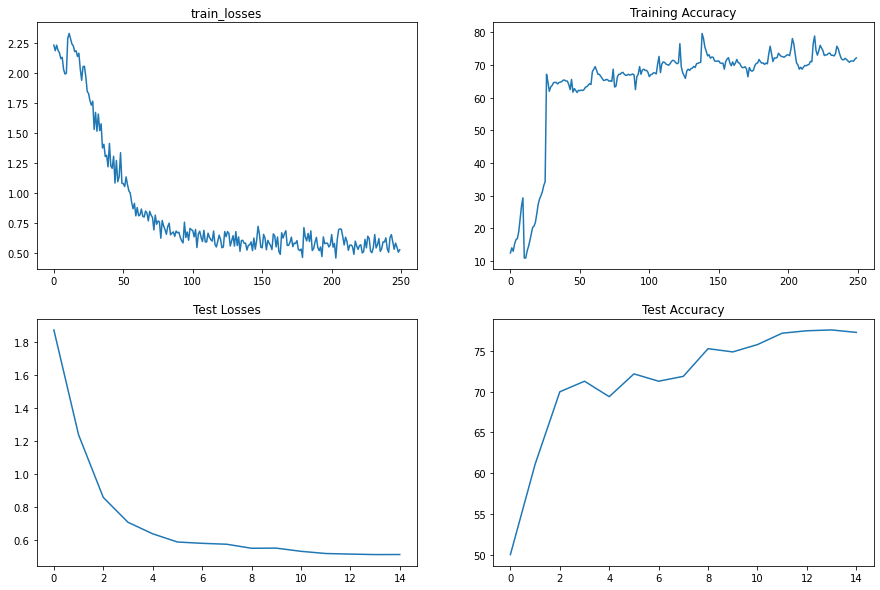

In [197]:
# Plotting the accuracy metrics
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title('train_losses')
axs[0,1].plot(train_acc)
axs[0,1].set_title('Training Accuracy')
axs[1,0].plot(test_losses)
axs[1,0].set_title('Test Losses')
axs[1,1].plot(test_acc)
axs[1,1].set_title('Test Accuracy')

In [ ]:
torch.save(model.state_dict(), 'model_15ep_75.6.pt')
